## Import Libraries

In [2]:
from tensorflow.keras.preprocessing.image import*
from tensorflow.keras.layers import*
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import*
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2
import os

## Dataset

In [3]:
directory = "D:\myFolder\SYNC INTERN'S\Face Mask Detection\dataset"
categories = ["with_mask", "without_mask"]

## Data preprocessing

In [4]:
data = []
labels =[]

for category in categories:
    path = os.path.join(directory, category)
    for image in os.listdir(path):
        img_path = os.path.join(path, image)
        img = load_img(img_path, target_size = (224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        
        data.append(img)
        labels.append(category)

labels = LabelBinarizer().fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

## Model training

In [5]:
#hyper parameters
LR = 0.0001
Epochs = 20
batch_size = 32

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

#data augmentation
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(learning_rate = LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=Epochs)

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

model.save("mask_detector.model", save_format="h5")

Epoch 1/20
95/95 [==============================] - 103s 1s/step - loss: 0.4341 - accuracy: 0.8441 - val_loss: 0.1819 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 98s 1s/step - loss: 0.1664 - accuracy: 0.9647 - val_loss: 0.0874 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 104s 1s/step - loss: 0.1086 - accuracy: 0.9720 - val_loss: 0.0617 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 94s 992ms/step - loss: 0.0841 - accuracy: 0.9776 - val_loss: 0.0503 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 96s 1s/step - loss: 0.0668 - accuracy: 0.9825 - val_loss: 0.0412 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 98s 1s/step - loss: 0.0622 - accuracy: 0.9815 - val_loss: 0.0365 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 98s 1s/step - loss: 0.0551 - accuracy: 0.9852 - val_loss: 0.0386 - val_accuracy: 0.9909
Epoch 8/20
95/9

## Loss and accuracy visualization

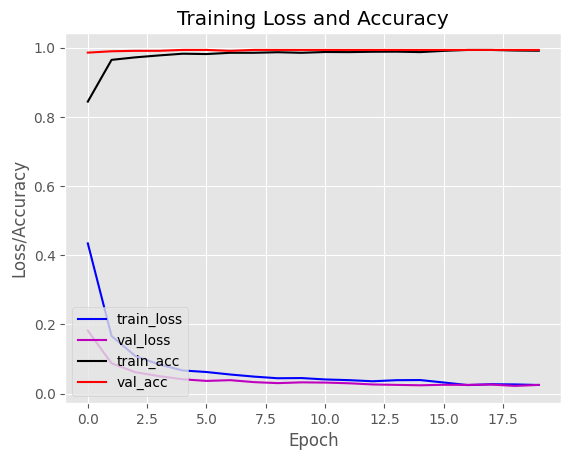

In [6]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,Epochs), H.history["loss"], label="train_loss", c='b')
plt.plot(np.arange(0, Epochs), H.history["val_loss"], label="val_loss", c='m')
plt.plot(np.arange(0, Epochs), H.history["accuracy"], label="train_acc", c='k')
plt.plot(np.arange(0, Epochs), H.history["val_accuracy"], label="val_acc", c='r')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Detection

In [7]:
def detect_and_predict_mask(frame, faceNet, maskNet):

    (h, w) = frame.shape[:2]
    #Create a binary large object from the frame
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

In [11]:
# load face detector model
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load face mask detector model
maskNet = load_model("mask_detector.model")

cap = cv2.VideoCapture("test1.mp4")

while True:
    ret, frame = cap.read()
    frame = imutils.resize(frame, width=400)

    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    
    for (box, pred) in zip(locs, preds):
            (startX, startY, endX, endY) = box
            (mask, withoutMask) = pred
    
            if mask > withoutMask:
                label = "Mask" 
            else: 
                label= "No Mask"
            
            if label == "Mask":
                color = (0, 255, 0) 
            
            else:
                color = (255, 0, 0)

            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Face Mask Detection", frame)
    
    key = cv2.waitKey(2) & 0xFF
    if key == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 69ms/step
